# Strategy Description: Adaptive Cointegration Pairs Trading (Gold vs. Silver)

### 1. Executive Summary
This strategy employs a **Statistical Arbitrage** approach, specifically focusing on the cointegration relationship between Gold (XAU) and Silver (XAG).

A key feature of this strategy is its **Adaptive Noise Reduction mechanism**. Since Silver (XAG) exhibits significantly higher volatility than Gold, the strategy dynamically adjusts the lookback period for the Hedge Ratio ($\beta$) calculation based on the current volatility regime. This filters out short-term noise during turbulent market conditions.

### 2. Investment Universe & Specifications
* **Asset A (Y):** Gold Futures (XAU)
    * Point Value: $100
    * Transaction Cost: $15 per trade
* **Asset B (X):** Silver Futures (XAG)
    * Point Value: $5,000
    * Transaction Cost: $10 per trade
* **Data Frequency:** 5-minute bars (Intraday)

### 3. Methodology

#### A. Volatility Regime Detection
The strategy monitors the rolling volatility of Silver to determine the market state.
* **Metric:** Rolling Standard Deviation of Silver returns (1-week window).
* **Threshold:** The 80th percentile of volatility over the past month (approx. 6,000 bars).
* **Logic:**
    * **Normal Regime:** Volatility $\le$ Threshold.
    * **High Volatility Regime:** Volatility $>$ Threshold.

#### B. Adaptive Hedge Ratio (Rolling OLS)　-> Advantages of this strats!!
[Rationale] Since valatility of Silver is much higher than Gold, during high vol periods, the short-term noise can distort the Hedge Ratio estimation. To mitigate this, the strategy adapts the regression window based on the detected regime.
The Hedge Ratio ($\beta$) is calculated using Rolling OLS on the Notional Values (Dollar Values) of the assets. The window size adapts to the regime:
* **Normal Window:** 1,500 bars (approx. 1 week). Used to capture recent trends.
* **High Vol Window:** 3,000 bars (approx. 2 weeks). Used to smooth out noise when volatility is high.

#### C. Spread Construction & Z-Score
The Spread is the residual of the relationship:
$$Spread = (Price_{XAU} \times 100) - \beta_{adaptive} \times (Price_{XAG} \times 5000)$$

To identify anomalies, a rolling **Z-Score** is calculated on this spread:
* **Z-Score Window:** 300 bars.
* **Formula:** $Z = \frac{Spread - \mu_{spread}}{\sigma_{spread}}$

### 4. Trading Logic

The strategy follows a Mean Reversion logic with a strict **1-Unit Constraint**:

* **Entry Signals:**
    * **Short Spread:** If $Z > 2.0$ (Gold expensive / Silver cheap) $\rightarrow$ **Sell Gold / Buy Silver**.
    * **Long Spread:** If $Z < -2.0$ (Gold cheap / Silver expensive) $\rightarrow$ **Buy Gold / Sell Silver**.

* **Exit Signals (Mean Reversion):**
    * Positions are closed when the spread reverts to the mean area ($|Z| < 0.5$).

* **Constraints:**
    * Max Position: 1 Unit Long or 1 Unit Short per asset.
    * **Out-of-Sample (OOS):** Trading is strictly disabled during OOS periods.

### 5. Risk Management
* **Regime Adaptation:** By extending the regression window during high volatility, the strategy reduces the likelihood of false signals caused by temporary price spikes in Silver.
* **Cost Efficiency:** The strategy targets large notional deviations (due to Silver's high point value), ensuring that successful mean reversions cover the fixed transaction costs.

[Info] Calculating Dynamic Beta & Z-Score (robust mode)...
  WINDOW_BETA_NORMAL=1500, WINDOW_BETA_HIGH_VOL=3000
  VOL_LOOKBACK=6000, VOL_THRESH_PCT=0.8
[Info] prepared rows: 122630, rows with usable Z_Score: 117365
[Info] Running Pairs Strategy: ENTRY=2.0, EXIT=1.0
[Info] approx trade events: 476.0

 PERFORMANCE REPORT: Adaptive Cointegration Strategy (XAU/XAG)
Quarter  Gross SR    Net SR  Ann. Vol ($)  Gross CR    Net CR  Gross CumP&L  Net CumP&L  Trades (Au)  Trades (Ag)  Av. Trades      Stat
2023_Q1 -0.275660 -0.590068  14371.440966 -0.572142 -1.110996       -1224.8     -2624.8         56.0         56.0    1.435897 -1.051920
2023_Q3 -1.706090 -2.011347  13963.477069 -2.927459 -3.161417       -7368.1     -8693.1         53.0         53.0    1.358974 -5.430863
2023_Q4  1.472098  1.046984  12655.426937  2.508545  1.712067        5776.2      4101.2         67.0         67.0    1.717949  0.771948
2024_Q2  3.114205  2.796964  20571.240565 14.040482 12.221118       20062.4     18037.4     

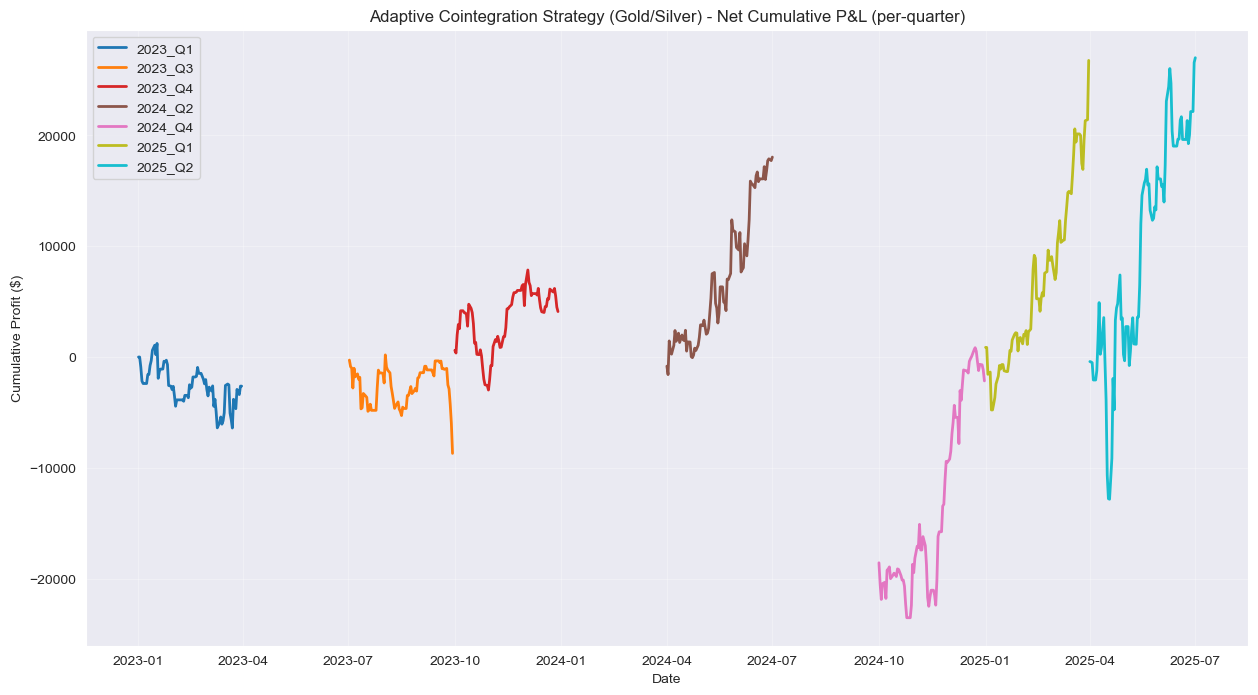

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')


# ==========================================
# 1. Configuration
# ==========================================
class Config:
    FILE_PATH = '../../preprocess/df_g2_processed.pkl'
    ASSETS = ['XAU', 'XAG']

    # Contract Specs
    SPECS = {
        'XAU': {'point_val': 100.0, 'cost': 15.0},
        'XAG': {'point_val': 5000.0, 'cost': 10.0}
    }

    # --- Strategy Parameters (user semantics kept) ---
    WINDOW_BETA_NORMAL = 1500
    WINDOW_BETA_HIGH_VOL = 3000

    VOL_PERCENTILE_LOOKBACK = 6000
    VOL_THRESHOLD_PERCENTILE = 0.80

    WINDOW_Z = 300
    ENTRY_THRESHOLD = 2.0
    EXIT_THRESHOLD = 1.0

    ANNUALIZATION = 252

    # Robustness knobs
    MIN_BETA_PERIOD = max(10, int(WINDOW_BETA_NORMAL * 0.05))
    MIN_BETA_HIGH_PERIOD = max(10, int(WINDOW_BETA_HIGH_VOL * 0.05))
    MIN_VOL_PERIOD = max(10, int(WINDOW_BETA_NORMAL * 0.05))
    MIN_Z_PERIOD = max(10, int(WINDOW_Z * 0.1))


# ==========================================
# 2. Data Preparation (Dynamic Beta, robust)
# ==========================================
def prepare_pairs_data(file_path, cfg):
    try:
        df = pd.read_pickle(file_path)
    except FileNotFoundError:
        print(f"[Error] File not found: {file_path}")
        return None

    # Required cols
    req_cols = set(cfg.ASSETS + ['Quarter_ID'])
    if 'Is_In_Sample' in df.columns:
        req_cols.add('Is_In_Sample')

    missing = req_cols.difference(df.columns)
    if missing:
        print(f"[Error] Missing columns: {missing}")
        return None

    data = df.copy()

    if 'Is_In_Sample' not in data.columns:
        data['Is_In_Sample'] = True

    print("[Info] Calculating Dynamic Beta & Z-Score (robust mode)...")
    print(f"  WINDOW_BETA_NORMAL={cfg.WINDOW_BETA_NORMAL}, WINDOW_BETA_HIGH_VOL={cfg.WINDOW_BETA_HIGH_VOL}")
    print(f"  VOL_LOOKBACK={cfg.VOL_PERCENTILE_LOOKBACK}, VOL_THRESH_PCT={cfg.VOL_THRESHOLD_PERCENTILE}")

    # Work in NOTIONAL units
    y = data['XAU'] * cfg.SPECS['XAU']['point_val']
    x = data['XAG'] * cfg.SPECS['XAG']['point_val']

    # Rolling returns for volatility (pct_change) - use small min_periods to start measuring
    x_ret = x.pct_change()

    # Rolling vol (normal window) - robust min_periods
    vol_x = x_ret.rolling(window=cfg.WINDOW_BETA_NORMAL, min_periods=cfg.MIN_VOL_PERIOD).std()

    # Rolling quantile threshold (may be NaN for early rows) - use min_periods
    vol_threshold = vol_x.rolling(window=cfg.VOL_PERCENTILE_LOOKBACK,
                                  min_periods=max(1, int(cfg.VOL_PERCENTILE_LOOKBACK * 0.1))).quantile(cfg.VOL_THRESHOLD_PERCENTILE)

    # is_high_vol boolean (elementwise). if vol_threshold is NaN, is_high_vol -> False
    is_high_vol = (vol_x > vol_threshold).fillna(False)

    # Rolling cov/var with min_periods to avoid full NaN
    cov_1w = x.rolling(window=cfg.WINDOW_BETA_NORMAL, min_periods=cfg.MIN_BETA_PERIOD).cov(y)
    var_1w = x.rolling(window=cfg.WINDOW_BETA_NORMAL, min_periods=cfg.MIN_BETA_PERIOD).var()
    cov_2w = x.rolling(window=cfg.WINDOW_BETA_HIGH_VOL, min_periods=cfg.MIN_BETA_HIGH_PERIOD).cov(y)
    var_2w = x.rolling(window=cfg.WINDOW_BETA_HIGH_VOL, min_periods=cfg.MIN_BETA_HIGH_PERIOD).var()

    # Protect against tiny variances -> make them NaN to avoid division blow-up
    var_1w_safe = var_1w.copy()
    var_1w_safe[var_1w_safe.abs() < 1e-8] = np.nan
    var_2w_safe = var_2w.copy()
    var_2w_safe[var_2w_safe.abs() < 1e-8] = np.nan

    beta_1w = cov_1w / var_1w_safe
    beta_2w = cov_2w / var_2w_safe

    # Replace infinite with NaN
    beta_1w = beta_1w.replace([np.inf, -np.inf], np.nan)
    beta_2w = beta_2w.replace([np.inf, -np.inf], np.nan)

    # Choose final beta using regime flag; result is an array aligned with index
    beta_final = pd.Series(np.where(is_high_vol.values, beta_2w.values, beta_1w.values), index=data.index)

    # Fill missing betas by forward/backfill, then final default 1.0
    beta_final = beta_final.fillna(method='ffill').fillna(method='bfill').fillna(1.0)

    # Spread and Z-score: compute in notional units
    spread = y - (beta_final * x)

    spread_mean = spread.rolling(window=cfg.WINDOW_Z, min_periods=cfg.MIN_Z_PERIOD).mean()
    spread_std = spread.rolling(window=cfg.WINDOW_Z, min_periods=cfg.MIN_Z_PERIOD).std()
    spread_std_safe = spread_std.copy()
    spread_std_safe[spread_std_safe.abs() < 1e-12] = np.nan

    z_score = (spread - spread_mean) / spread_std_safe

    # Put back to DataFrame
    data = data.assign(Beta=beta_final.values,
                       Beta_Mode=np.where(is_high_vol.values, '2W (High Vol)', '1W (Normal)'),
                       Spread=spread.values,
                       Z_Score=z_score.values,
                       Vol_XAG=vol_x.values)

    # Do NOT drop all NaNs; strategy will skip NaN z-scores
    n_total = len(data)
    n_z = data['Z_Score'].notna().sum()
    print(f"[Info] prepared rows: {n_total}, rows with usable Z_Score: {n_z}")

    return data


# ==========================================
# 3. Strategy Logic (unchanged, robust NaN handling)
# ==========================================
def run_pairs_strategy(df, cfg):
    data = df.copy()
    if data.empty:
        print("[Warning] empty dataframe to strategy")
        return data

    z_scores = data['Z_Score'].values
    in_sample = data['Is_In_Sample'].values if 'Is_In_Sample' in data.columns else np.ones(len(data), dtype=bool)

    pos_xau = np.zeros(len(data), dtype=int)
    pos_xag = np.zeros(len(data), dtype=int)
    curr_pos_xau = 0
    curr_pos_xag = 0

    print(f"[Info] Running Pairs Strategy: ENTRY={cfg.ENTRY_THRESHOLD}, EXIT={cfg.EXIT_THRESHOLD}")

    for i in range(len(data)):
        if not in_sample[i]:
            curr_pos_xau = 0
            curr_pos_xag = 0
            pos_xau[i] = 0
            pos_xag[i] = 0
            continue

        z = z_scores[i]
        # If z is NaN => skip (hold current pos)
        if np.isnan(z):
            pos_xau[i] = curr_pos_xau
            pos_xag[i] = curr_pos_xag
            continue

        # Entry
        if curr_pos_xau == 0 and curr_pos_xag == 0:
            if z > cfg.ENTRY_THRESHOLD:
                curr_pos_xau = -1
                curr_pos_xag = 1
            elif z < -cfg.ENTRY_THRESHOLD:
                curr_pos_xau = 1
                curr_pos_xag = -1
        else:
            # Exit if mean reversion
            if abs(z) < cfg.EXIT_THRESHOLD:
                curr_pos_xau = 0
                curr_pos_xag = 0

        pos_xau[i] = curr_pos_xau
        pos_xag[i] = curr_pos_xag

    # Shift positions by one bar (no look-ahead)
    data['Pos_XAU'] = pd.Series(pos_xau, index=data.index).shift(1).fillna(0).astype(int)
    data['Pos_XAG'] = pd.Series(pos_xag, index=data.index).shift(1).fillna(0).astype(int)

    # debug trades approx
    n_trades = (data['Pos_XAU'].diff().abs().sum() + data['Pos_XAG'].diff().abs().sum()) / 2.0
    print(f"[Info] approx trade events: {n_trades}")

    return data


# ==========================================
# 4. P&L calculation & aggregation
# ==========================================
def calculate_metrics(data, cfg):
    df = data.copy()
    if df.empty:
        return pd.DataFrame()

    df['dPrice_XAU'] = df['XAU'].diff()
    df['dPrice_XAG'] = df['XAG'].diff()

    df['Gross_PnL_XAU'] = df['Pos_XAU'] * df['dPrice_XAU'] * cfg.SPECS['XAU']['point_val']
    df['Gross_PnL_XAG'] = df['Pos_XAG'] * df['dPrice_XAG'] * cfg.SPECS['XAG']['point_val']
    df['Gross_PnL_Total'] = df['Gross_PnL_XAU'].fillna(0) + df['Gross_PnL_XAG'].fillna(0)

    df['Trades_XAU'] = df['Pos_XAU'].diff().abs().fillna(0)
    df['Trades_XAG'] = df['Pos_XAG'].diff().abs().fillna(0)

    df['Cost_Total'] = (df['Trades_XAU'] * cfg.SPECS['XAU']['cost']) + (df['Trades_XAG'] * cfg.SPECS['XAG']['cost'])

    df['Net_PnL_Total'] = df['Gross_PnL_Total'] - df['Cost_Total']
    df['Total_Trades'] = df['Trades_XAU'] + df['Trades_XAG']

    daily_stats = df.resample('D').agg({
        'Gross_PnL_Total': 'sum',
        'Net_PnL_Total': 'sum',
        'Total_Trades': 'sum',
        'Trades_XAU': 'sum',
        'Trades_XAG': 'sum',
        'Quarter_ID': 'last',
        'Is_In_Sample': 'last'
    })

    daily_stats = daily_stats[daily_stats['Quarter_ID'].notna()]
    daily_stats = daily_stats[daily_stats['Is_In_Sample'] == True]

    return daily_stats


# ==========================================
# 5. Reporting
# ==========================================
def generate_quarterly_stats(daily_df, cfg):
    if daily_df.empty:
        return pd.DataFrame()

    quarters = sorted(daily_df['Quarter_ID'].unique())
    stats_list = []

    for q in quarters:
        d_q = daily_df[daily_df['Quarter_ID'] == q].copy()
        if len(d_q) == 0:
            continue

        gross_cum_pnl = d_q['Gross_PnL_Total'].sum()
        net_cum_pnl = d_q['Net_PnL_Total'].sum()

        mean_g = d_q['Gross_PnL_Total'].mean()
        std_g = d_q['Gross_PnL_Total'].std()
        gross_sr = (mean_g / std_g * np.sqrt(cfg.ANNUALIZATION)) if (std_g and not np.isnan(std_g)) else 0

        mean_n = d_q['Net_PnL_Total'].mean()
        std_n = d_q['Net_PnL_Total'].std()
        net_sr = (mean_n / std_n * np.sqrt(cfg.ANNUALIZATION)) if (std_n and not np.isnan(std_n)) else 0

        ann_vol_n = std_n * np.sqrt(cfg.ANNUALIZATION) if (std_n and not np.isnan(std_n)) else 0

        years = len(d_q) / cfg.ANNUALIZATION if cfg.ANNUALIZATION > 0 else 1.0

        equity_g = d_q['Gross_PnL_Total'].cumsum()
        max_dd_g = (equity_g.cummax() - equity_g).max()
        gross_cr = (gross_cum_pnl / years / max_dd_g) if (max_dd_g and max_dd_g > 0) else 0

        equity_n = d_q['Net_PnL_Total'].cumsum()
        max_dd_n = (equity_n.cummax() - equity_n).max()
        net_cr = (net_cum_pnl / years / max_dd_n) if (max_dd_n and max_dd_n > 0) else 0

        trades_xau = d_q['Trades_XAU'].sum()
        trades_xag = d_q['Trades_XAG'].sum()
        av_ntrades = d_q['Total_Trades'].mean()

        abs_pnl_scaled = abs(net_cum_pnl) / 1000.0
        log_term = np.log(abs_pnl_scaled) if abs_pnl_scaled > 0 else 0
        term_2 = max(0, log_term)
        stat = (net_sr - 0.5) * term_2

        stats_list.append({
            'Quarter': q,
            'Gross SR': gross_sr,
            'Net SR': net_sr,
            'Ann. Vol ($)': ann_vol_n,
            'Gross CR': gross_cr,
            'Net CR': net_cr,
            'Gross CumP&L': gross_cum_pnl,
            'Net CumP&L': net_cum_pnl,
            'Trades (Au)': trades_xau,
            'Trades (Ag)': trades_xag,
            'Av. Trades': av_ntrades,
            'Stat': stat
        })

    return pd.DataFrame(stats_list)


# ==========================================
# 6. Plot
# ==========================================
def plot_equity_curve(daily_stats):
    if daily_stats is None or daily_stats.empty:
        return

    quarters = sorted(daily_stats['Quarter_ID'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(quarters)))

    plt.figure(figsize=(15, 8))
    # per-quarter cumulative plot
    for i, q in enumerate(quarters):
        d_q = daily_stats[daily_stats['Quarter_ID'] == q].sort_index()
        equity = d_q['Net_PnL_Total'].cumsum()
        plt.plot(equity.index, equity.values, label=q, color=colors[i], lw=2)

    plt.title('Adaptive Cointegration Strategy (Gold/Silver) - Net Cumulative P&L (per-quarter)')
    plt.ylabel('Cumulative Profit ($)')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


# ==========================================
# 7. Main Execution
# ==========================================
if __name__ == "__main__":
    cfg = Config()
    df_prep = prepare_pairs_data(cfg.FILE_PATH, cfg)

    if df_prep is None or df_prep.empty:
        print("[Error] No data prepared. Exiting.")
    else:
        df_res = run_pairs_strategy(df_prep, cfg)
        daily_data = calculate_metrics(df_res, cfg)
        stats_table = generate_quarterly_stats(daily_data, cfg)

        print("\n" + "="*80)
        print(" PERFORMANCE REPORT: Adaptive Cointegration Strategy (XAU/XAG)")
        print("="*80)

        if not stats_table.empty:
            total_score = stats_table['Stat'].sum()
            total_gross_pnl = stats_table['Gross CumP&L'].sum()
            total_net_pnl = stats_table['Net CumP&L'].sum()
            total_trades_au = stats_table['Trades (Au)'].sum()
            total_trades_ag = stats_table['Trades (Ag)'].sum()

            std_global = daily_data['Net_PnL_Total'].std()
            vol_global = std_global * np.sqrt(cfg.ANNUALIZATION) if not np.isnan(std_global) else 0.0

            display_df = stats_table.copy()
            sum_row = pd.DataFrame([{
                'Quarter': 'TOTAL',
                'Gross SR': np.nan,
                'Net SR': np.nan,
                'Ann. Vol ($)': vol_global,
                'Gross CR': np.nan,
                'Net CR': np.nan,
                'Gross CumP&L': total_gross_pnl,
                'Net CumP&L': total_net_pnl,
                'Trades (Au)': total_trades_au,
                'Trades (Ag)': total_trades_ag,
                'Av. Trades': stats_table['Av. Trades'].mean(),
                'Stat': total_score
            }])

            display_df = pd.concat([display_df, sum_row], ignore_index=True)
            print(display_df.to_string(index=False))
            print(f"\nTOTAL RANKING SCORE: {total_score:.4f}")

            # Plot
            if not daily_data.empty:
                plot_equity_curve(daily_data)
        else:
            print("⚠️ No statistics generated.")


[Info] Calculating Dynamic Beta & Z-Score (robust mode)...
  WINDOW_BETA_NORMAL=1500, WINDOW_BETA_HIGH_VOL=3000
  VOL_LOOKBACK=6000, VOL_THRESH_PCT=0.8
[Info] prepared rows: 122630, rows with usable Z_Score: 117365
[Info] Running Pairs Strategy: ENTRY=2.0, EXIT=1.0
[Info] approx trade events: 476.0

 PERFORMANCE REPORT: Adaptive Cointegration Strategy (XAU/XAG)
Quarter  Gross SR    Net SR  Ann. Vol ($)  Gross CR    Net CR  Gross CumP&L  Net CumP&L  Trades (Au)  Trades (Ag)  Av. Trades      Stat
2023_Q1 -0.275660 -0.590068  14371.440966 -0.572142 -1.110996       -1224.8     -2624.8         56.0         56.0    1.435897 -1.051920
2023_Q3 -1.706090 -2.011347  13963.477069 -2.927459 -3.161417       -7368.1     -8693.1         53.0         53.0    1.358974 -5.430863
2023_Q4  1.472098  1.046984  12655.426937  2.508545  1.712067        5776.2      4101.2         67.0         67.0    1.717949  0.771948
2024_Q2  3.114205  2.796964  20571.240565 14.040482 12.221118       20062.4     18037.4     

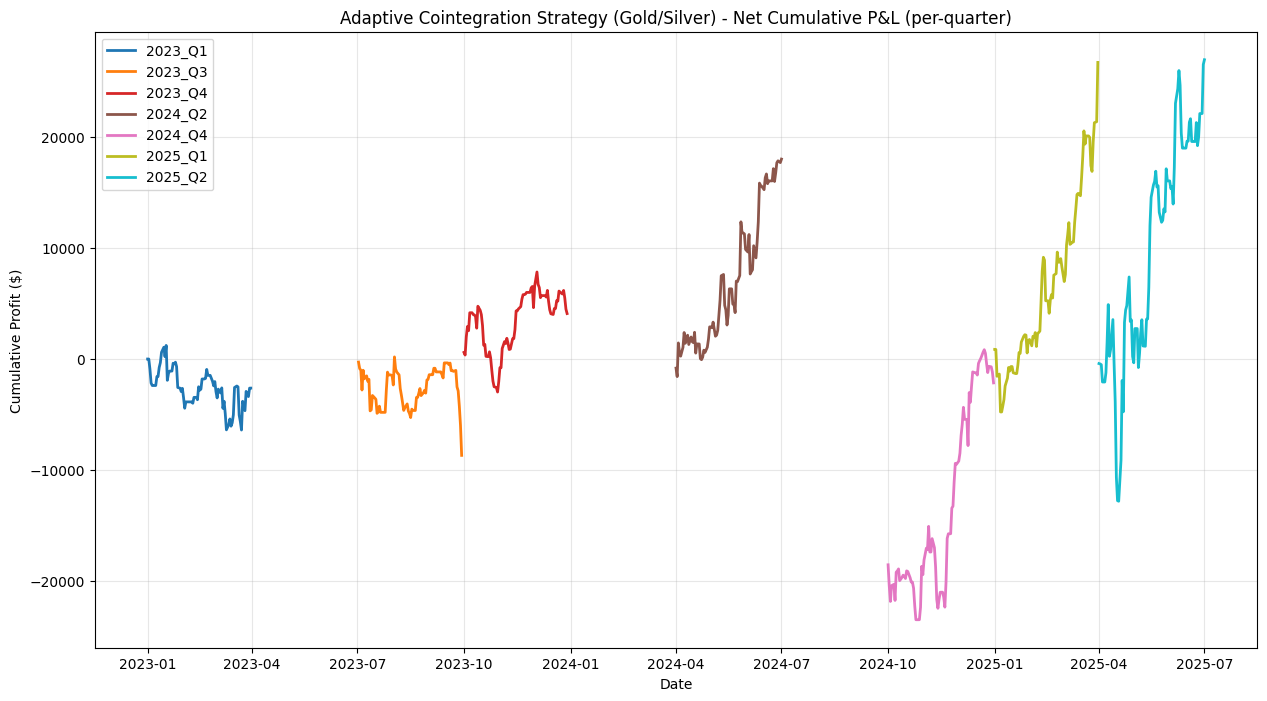

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')


# ==========================================
# 1. Configuration
# ==========================================
class Config:   
    FILE_PATH = '../../preprocess/df_g2_processed.pkl'
    ASSETS = ['XAU', 'XAG']

    # Contract Specs
    SPECS = {
        'XAU': {'point_val': 100.0, 'cost': 15.0},
        'XAG': {'point_val': 5000.0, 'cost': 10.0}
    }

    # --- Strategy Parameters (user semantics kept) ---
    WINDOW_BETA_NORMAL = 1500
    WINDOW_BETA_HIGH_VOL = 3000

    VOL_PERCENTILE_LOOKBACK = 6000
    VOL_THRESHOLD_PERCENTILE = 0.80

    WINDOW_Z = 300
    ENTRY_THRESHOLD = 2.0
    EXIT_THRESHOLD = 1.0

    ANNUALIZATION = 252

    # Robustness knobs
    MIN_BETA_PERIOD = max(10, int(WINDOW_BETA_NORMAL * 0.05))
    MIN_BETA_HIGH_PERIOD = max(10, int(WINDOW_BETA_HIGH_VOL * 0.05))
    MIN_VOL_PERIOD = max(10, int(WINDOW_BETA_NORMAL * 0.05))
    MIN_Z_PERIOD = max(10, int(WINDOW_Z * 0.1))


# ==========================================
# 2. Data Preparation (Dynamic Beta, robust)
# ==========================================
def prepare_pairs_data(file_path, cfg):
    try:
        df = pd.read_pickle(file_path)
    except FileNotFoundError:
        print(f"[Error] File not found: {file_path}")
        return None

    # Required cols
    req_cols = set(cfg.ASSETS + ['Quarter_ID'])
    if 'Is_In_Sample' in df.columns:
        req_cols.add('Is_In_Sample')

    missing = req_cols.difference(df.columns)
    if missing:
        print(f"[Error] Missing columns: {missing}")
        return None

    data = df.copy()

    if 'Is_In_Sample' not in data.columns:
        data['Is_In_Sample'] = True

    print("[Info] Calculating Dynamic Beta & Z-Score (robust mode)...")
    print(f"  WINDOW_BETA_NORMAL={cfg.WINDOW_BETA_NORMAL}, WINDOW_BETA_HIGH_VOL={cfg.WINDOW_BETA_HIGH_VOL}")
    print(f"  VOL_LOOKBACK={cfg.VOL_PERCENTILE_LOOKBACK}, VOL_THRESH_PCT={cfg.VOL_THRESHOLD_PERCENTILE}")

    # Work in NOTIONAL units
    y = data['XAU'] * cfg.SPECS['XAU']['point_val']
    x = data['XAG'] * cfg.SPECS['XAG']['point_val']

    # Rolling returns for volatility (pct_change) - use small min_periods to start measuring
    x_ret = x.pct_change()

    # Rolling vol (normal window) - robust min_periods
    vol_x = x_ret.rolling(window=cfg.WINDOW_BETA_NORMAL, min_periods=cfg.MIN_VOL_PERIOD).std()

    # Rolling quantile threshold (may be NaN for early rows) - use min_periods
    vol_threshold = vol_x.rolling(window=cfg.VOL_PERCENTILE_LOOKBACK,
                                  min_periods=max(1, int(cfg.VOL_PERCENTILE_LOOKBACK * 0.1))).quantile(cfg.VOL_THRESHOLD_PERCENTILE)

    # is_high_vol boolean (elementwise). if vol_threshold is NaN, is_high_vol -> False
    is_high_vol = (vol_x > vol_threshold).fillna(False)

    # Rolling cov/var with min_periods to avoid full NaN
    cov_1w = x.rolling(window=cfg.WINDOW_BETA_NORMAL, min_periods=cfg.MIN_BETA_PERIOD).cov(y)
    var_1w = x.rolling(window=cfg.WINDOW_BETA_NORMAL, min_periods=cfg.MIN_BETA_PERIOD).var()
    cov_2w = x.rolling(window=cfg.WINDOW_BETA_HIGH_VOL, min_periods=cfg.MIN_BETA_HIGH_PERIOD).cov(y)
    var_2w = x.rolling(window=cfg.WINDOW_BETA_HIGH_VOL, min_periods=cfg.MIN_BETA_HIGH_PERIOD).var()

    # Protect against tiny variances -> make them NaN to avoid division blow-up
    var_1w_safe = var_1w.copy()
    var_1w_safe[var_1w_safe.abs() < 1e-8] = np.nan
    var_2w_safe = var_2w.copy()
    var_2w_safe[var_2w_safe.abs() < 1e-8] = np.nan

    beta_1w = cov_1w / var_1w_safe
    beta_2w = cov_2w / var_2w_safe

    # Replace infinite with NaN
    beta_1w = beta_1w.replace([np.inf, -np.inf], np.nan)
    beta_2w = beta_2w.replace([np.inf, -np.inf], np.nan)

    # Choose final beta using regime flag; result is an array aligned with index
    beta_final = pd.Series(np.where(is_high_vol.values, beta_2w.values, beta_1w.values), index=data.index)

    # Fill missing betas by forward/backfill, then final default 1.0
    beta_final = beta_final.fillna(method='ffill').fillna(method='bfill').fillna(1.0)

    # Spread and Z-score: compute in notional units
    spread = y - (beta_final * x)

    spread_mean = spread.rolling(window=cfg.WINDOW_Z, min_periods=cfg.MIN_Z_PERIOD).mean()
    spread_std = spread.rolling(window=cfg.WINDOW_Z, min_periods=cfg.MIN_Z_PERIOD).std()
    spread_std_safe = spread_std.copy()
    spread_std_safe[spread_std_safe.abs() < 1e-12] = np.nan

    z_score = (spread - spread_mean) / spread_std_safe

    # Put back to DataFrame
    data = data.assign(Beta=beta_final.values,
                       Beta_Mode=np.where(is_high_vol.values, '2W (High Vol)', '1W (Normal)'),
                       Spread=spread.values,
                       Z_Score=z_score.values,
                       Vol_XAG=vol_x.values)

    # Do NOT drop all NaNs; strategy will skip NaN z-scores
    n_total = len(data)
    n_z = data['Z_Score'].notna().sum()
    print(f"[Info] prepared rows: {n_total}, rows with usable Z_Score: {n_z}")

    return data


# ==========================================
# 3. Strategy Logic (unchanged, robust NaN handling)
# ==========================================
def run_pairs_strategy(df, cfg):
    data = df.copy()
    if data.empty:
        print("[Warning] empty dataframe to strategy")
        return data

    z_scores = data['Z_Score'].values
    in_sample = data['Is_In_Sample'].values if 'Is_In_Sample' in data.columns else np.ones(len(data), dtype=bool)

    pos_xau = np.zeros(len(data), dtype=int)
    pos_xag = np.zeros(len(data), dtype=int)
    curr_pos_xau = 0
    curr_pos_xag = 0

    print(f"[Info] Running Pairs Strategy: ENTRY={cfg.ENTRY_THRESHOLD}, EXIT={cfg.EXIT_THRESHOLD}")

    for i in range(len(data)):
        if not in_sample[i]:
            curr_pos_xau = 0
            curr_pos_xag = 0
            pos_xau[i] = 0
            pos_xag[i] = 0
            continue

        z = z_scores[i]
        # If z is NaN => skip (hold current pos)
        if np.isnan(z):
            pos_xau[i] = curr_pos_xau
            pos_xag[i] = curr_pos_xag
            continue

        # Entry
        if curr_pos_xau == 0 and curr_pos_xag == 0:
            if z > cfg.ENTRY_THRESHOLD:
                curr_pos_xau = -1
                curr_pos_xag = 1
            elif z < -cfg.ENTRY_THRESHOLD:
                curr_pos_xau = 1
                curr_pos_xag = -1
        else:
            # Exit if mean reversion
            if abs(z) < cfg.EXIT_THRESHOLD:
                curr_pos_xau = 0
                curr_pos_xag = 0

        pos_xau[i] = curr_pos_xau
        pos_xag[i] = curr_pos_xag

    # Shift positions by one bar (no look-ahead)
    data['Pos_XAU'] = pd.Series(pos_xau, index=data.index).shift(1).fillna(0).astype(int)
    data['Pos_XAG'] = pd.Series(pos_xag, index=data.index).shift(1).fillna(0).astype(int)

    # debug trades approx
    n_trades = (data['Pos_XAU'].diff().abs().sum() + data['Pos_XAG'].diff().abs().sum()) / 2.0
    print(f"[Info] approx trade events: {n_trades}")

    return data


# ==========================================
# 4. P&L calculation & aggregation
# ==========================================
def calculate_metrics(data, cfg):
    df = data.copy()
    if df.empty:
        return pd.DataFrame()

    df['dPrice_XAU'] = df['XAU'].diff()
    df['dPrice_XAG'] = df['XAG'].diff()

    df['Gross_PnL_XAU'] = df['Pos_XAU'] * df['dPrice_XAU'] * cfg.SPECS['XAU']['point_val']
    df['Gross_PnL_XAG'] = df['Pos_XAG'] * df['dPrice_XAG'] * cfg.SPECS['XAG']['point_val']
    df['Gross_PnL_Total'] = df['Gross_PnL_XAU'].fillna(0) + df['Gross_PnL_XAG'].fillna(0)

    df['Trades_XAU'] = df['Pos_XAU'].diff().abs().fillna(0)
    df['Trades_XAG'] = df['Pos_XAG'].diff().abs().fillna(0)

    df['Cost_Total'] = (df['Trades_XAU'] * cfg.SPECS['XAU']['cost']) + (df['Trades_XAG'] * cfg.SPECS['XAG']['cost'])

    df['Net_PnL_Total'] = df['Gross_PnL_Total'] - df['Cost_Total']
    df['Total_Trades'] = df['Trades_XAU'] + df['Trades_XAG']

    daily_stats = df.resample('D').agg({
        'Gross_PnL_Total': 'sum',
        'Net_PnL_Total': 'sum',
        'Total_Trades': 'sum',
        'Trades_XAU': 'sum',
        'Trades_XAG': 'sum',
        'Quarter_ID': 'last',
        'Is_In_Sample': 'last'
    })

    daily_stats = daily_stats[daily_stats['Quarter_ID'].notna()]
    daily_stats = daily_stats[daily_stats['Is_In_Sample'] == True]

    return daily_stats


# ==========================================
# 5. Reporting
# ==========================================
def generate_quarterly_stats(daily_df, cfg):
    if daily_df.empty:
        return pd.DataFrame()

    quarters = sorted(daily_df['Quarter_ID'].unique())
    stats_list = []

    for q in quarters:
        d_q = daily_df[daily_df['Quarter_ID'] == q].copy()
        if len(d_q) == 0:
            continue

        gross_cum_pnl = d_q['Gross_PnL_Total'].sum()
        net_cum_pnl = d_q['Net_PnL_Total'].sum()

        mean_g = d_q['Gross_PnL_Total'].mean()
        std_g = d_q['Gross_PnL_Total'].std()
        gross_sr = (mean_g / std_g * np.sqrt(cfg.ANNUALIZATION)) if (std_g and not np.isnan(std_g)) else 0

        mean_n = d_q['Net_PnL_Total'].mean()
        std_n = d_q['Net_PnL_Total'].std()
        net_sr = (mean_n / std_n * np.sqrt(cfg.ANNUALIZATION)) if (std_n and not np.isnan(std_n)) else 0

        ann_vol_n = std_n * np.sqrt(cfg.ANNUALIZATION) if (std_n and not np.isnan(std_n)) else 0

        years = len(d_q) / cfg.ANNUALIZATION if cfg.ANNUALIZATION > 0 else 1.0

        equity_g = d_q['Gross_PnL_Total'].cumsum()
        max_dd_g = (equity_g.cummax() - equity_g).max()
        gross_cr = (gross_cum_pnl / years / max_dd_g) if (max_dd_g and max_dd_g > 0) else 0

        equity_n = d_q['Net_PnL_Total'].cumsum()
        max_dd_n = (equity_n.cummax() - equity_n).max()
        net_cr = (net_cum_pnl / years / max_dd_n) if (max_dd_n and max_dd_n > 0) else 0

        trades_xau = d_q['Trades_XAU'].sum()
        trades_xag = d_q['Trades_XAG'].sum()
        av_ntrades = d_q['Total_Trades'].mean()

        abs_pnl_scaled = abs(net_cum_pnl) / 1000.0
        log_term = np.log(abs_pnl_scaled) if abs_pnl_scaled > 0 else 0
        term_2 = max(0, log_term)
        stat = (net_sr - 0.5) * term_2

        stats_list.append({
            'Quarter': q,
            'Gross SR': gross_sr,
            'Net SR': net_sr,
            'Ann. Vol ($)': ann_vol_n,
            'Gross CR': gross_cr,
            'Net CR': net_cr,
            'Gross CumP&L': gross_cum_pnl,
            'Net CumP&L': net_cum_pnl,
            'Trades (Au)': trades_xau,
            'Trades (Ag)': trades_xag,
            'Av. Trades': av_ntrades,
            'Stat': stat
        })

    return pd.DataFrame(stats_list)


# ==========================================
# 6. Plot
# ==========================================
def plot_equity_curve(daily_stats):
    if daily_stats is None or daily_stats.empty:
        return

    quarters = sorted(daily_stats['Quarter_ID'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(quarters)))

    plt.figure(figsize=(15, 8))
    # per-quarter cumulative plot
    for i, q in enumerate(quarters):
        d_q = daily_stats[daily_stats['Quarter_ID'] == q].sort_index()
        equity = d_q['Net_PnL_Total'].cumsum()
        plt.plot(equity.index, equity.values, label=q, color=colors[i], lw=2)

    plt.title('Adaptive Cointegration Strategy (Gold/Silver) - Net Cumulative P&L (per-quarter)')
    plt.ylabel('Cumulative Profit ($)')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


# ==========================================
# 7. Main Execution
# ==========================================
if __name__ == "__main__":
    cfg = Config()
    df_prep = prepare_pairs_data(cfg.FILE_PATH, cfg)

    if df_prep is None or df_prep.empty:
        print("[Error] No data prepared. Exiting.")
    else:
        df_res = run_pairs_strategy(df_prep, cfg)
        daily_data = calculate_metrics(df_res, cfg)
        stats_table = generate_quarterly_stats(daily_data, cfg)

        print("\n" + "="*80)
        print(" PERFORMANCE REPORT: Adaptive Cointegration Strategy (XAU/XAG)")
        print("="*80)

        if not stats_table.empty:
            total_score = stats_table['Stat'].sum()
            total_gross_pnl = stats_table['Gross CumP&L'].sum()
            total_net_pnl = stats_table['Net CumP&L'].sum()
            total_trades_au = stats_table['Trades (Au)'].sum()
            total_trades_ag = stats_table['Trades (Ag)'].sum()

            std_global = daily_data['Net_PnL_Total'].std()
            vol_global = std_global * np.sqrt(cfg.ANNUALIZATION) if not np.isnan(std_global) else 0.0

            display_df = stats_table.copy()
            sum_row = pd.DataFrame([{
                'Quarter': 'TOTAL',
                'Gross SR': np.nan,
                'Net SR': np.nan,
                'Ann. Vol ($)': vol_global,
                'Gross CR': np.nan,
                'Net CR': np.nan,
                'Gross CumP&L': total_gross_pnl,
                'Net CumP&L': total_net_pnl,
                'Trades (Au)': total_trades_au,
                'Trades (Ag)': total_trades_ag,
                'Av. Trades': stats_table['Av. Trades'].mean(),
                'Stat': total_score
            }])

            display_df = pd.concat([display_df, sum_row], ignore_index=True)
            print(display_df.to_string(index=False))
            print(f"\nTOTAL RANKING SCORE: {total_score:.4f}")

            # Plot
            if not daily_data.empty:
                plot_equity_curve(daily_data)
        else:
            print("⚠️ No statistics generated.")
